# Darcy Flow
Including forward and inverse problem solver for 1D. Darcy Flow
Darcy Flow
\begin{equation}
    \nabla \cdot ( k(x) \nabla u(x) ) = f(x)
\end{equation}

Zero Dirichlet boundary conditions $u(0) = u(1) = 0$

## Hints from Tim Sullivan

Express $u$ as $u(x) = \sum_{j = 1}^{n} u_{j} \phi_{j}(x)$ with $\phi_{j}(x) =$ piecewise linear tent function peaking at node $j$

Solve $A(u_{1}, …, u_{n}) = b$ for the coefficients  
\begin{align}
b_{j} &= \int_{0}^{1} f(x) \phi_{j}(x) d x \\
A_{i j} &= \int_{0}^{1} k(x) \phi'_{i}(x) \phi'_{j}(x) d x
\end{align}
Google finite element method / Galerkin method for elliptic PDE 

I will give you e.g. (u(1/4), u(1/2), u(3/4)) and similarly for f, both corrupted by additive N(0, \sigma^{2}) noise.
Your challenge:  infer k

--

Modelling assumption:  $k(x) = exp( \sum_{\alpha = 0}^{A} k_{\alpha} \phi_{\alpha}(x) )$

--

Try a Fourier basis. Note that u vanishes at the boundary, but that doesn't mean k does.

Create the forward model. Solver works. Extend to imitation inverse model with likelihood, etc. Use this to solve his problem.


# The Darcy Flow Problem

We consider the Darcy Flow problem in one dimension with Dirichlet boundry conditions and a modeling assumption.

\begin{align}
    k'(x) u'(x) + k(x) u''(x) &= f(x) \\
    u(0) = u(1) &= 0 \\
    exp( \sum_{\alpha = 0}^{A} k_{\alpha} \phi_{\alpha}(x) ) &=  k(x)
\end{align}

We put the equation into the weak form. $v(x)$ is a function which satisfies the boundary conditions.

\begin{equation}
    \int_{0}^{1} f(x)v(x) \ dx = \int_{0}^{1} (k'(x) u'(x) v(x) + k(x) u''(x) v(x)) \ dx
\end{equation}

We can integrate by parts and apply our boundry conditions on the second R.H.S. term to arrive at the next equation.

\begin{align}
    \int_{0}^{1} f(x)v(x) \ dx &= \int_{0}^{1} k'(x) u'(x) v(x) \ dx +
                                  k(x) u'(x) v(x) |_{0}^{1} - 
                                  \int_{0}^{1} k'(x) u'(x) v(x) \ dx - 
                                  \int_{0}^{1} k(x) u'(x) v'(x) \ dx \\
    \int_{0}^{1} f(x)v(x) \ dx &= - \int_{0}^{1} k(x) u'(x) v'(x) \ dx
\end{align}

We choose the piecewise linear function $v_k$ for a discretization.

\begin{equation}
v_{k}(x) = 
    \begin{cases}
        \frac{x-x_{k-1}}{x_k-x_{k-1}} & \text{if } x \in [x_{k-1}, x_k] \\
        \frac{x_{k+1}-x}{x_{k+1}-x_k} & \text{if } x \in [x_{k}, x_{k+1}] \\
        0 & \text{otherwise}
    \end{cases}
\end{equation}

If we expand $u(x)$ in a basis of tent functions on this discretization, we are left with the problem

\begin{equation}
    A \bf{u} = \bf{b}
\end{equation}

where $A_{ij} = - \int_{0}^{1} k(x) v_{i}'(x) v_{j}'(x) \ dx$ and $b_{j} = \int_{0}^{1} f(x) v_{j} dx$. Note that this will be a sparse matrix due our use of tent functions. With our modeling assumption, only 

## Useful Links
https://en.wikipedia.org/wiki/Finite_element_method  
http://www.mathematik.uni-dortmund.de/~kuzmin/Transport.pdf  

# Forward Solver

In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

In [2]:
def grid(nodes):
    return np.linspace(0, 1, num=nodes)
    
def tent(x, k, grid):
    def down(x):
        return (grid[k+1] - x) / (grid[k+1] - grid[k])
    def up(x):
        return (x - grid[k-1]) / (grid[k] - grid[k-1])
    if (k < 0) or (k > grid.size - 1):
        raise ValueError('k was not in [0, grid.size - 1]')
    elif k == 0:
        if (grid[k] <= x) and (x <= grid[k+1]):
            return down(x)
        else:
            return 0
    elif k == grid.size - 1:
        if (grid[k-1] <= x) and (x <= grid[k]):
            return up(x)
        else:
            return 0
    else:
        if (grid[k-1] <= x) and (x <= grid[k]):
            return up(x)
        elif (grid[k] <= x) and (x <= grid[k+1]):
            return down(x)
        else:
            return 0
        
def κ(x, coefs, grid):
    lo_bound = np.searchsorted(grid, x, 'left')
    up_bound = np.searchsorted(grid, x, 'right')
    
    if (0 - 0.1 <= x) and (x < grid[1]):
        return np.exp(sum([coefs[0] * tent(x, 0, grid), coefs[1] * tent(x, 1, grid)]))
    elif (grid[-2] < x) and (x <= grid[-1] + 0.1):
        return np.exp(sum([coefs[-2] * tent(x, grid.size - 2, grid), coefs[-1] * tent(x, grid.size - 1, grid)]))
    else:
        return np.exp(sum([coefs[k] * tent(x, k, grid) for k in [lo_bound, up_bound]]))
    
# def kappa(x, coefs, grid):
#     return np.exp(sum([coefs[k] * tent(x, k, grid) for k in range(grid.size)]))

def A(k, grid):
    val = lambda x, y: scipy.integrate.quad(k, x, y, limit=100)[0]
    lo_di = np.asarray([ val(grid[i-1], grid[i]  ) for i in range(2, grid.size - 1)])
    di    = np.asarray([-val(grid[i-1], grid[i+1]) for i in range(1, grid.size - 1)])
    up_di = np.asarray([ val(grid[i]  , grid[i+1]) for i in range(1, grid.size - 2)])
    
    return np.sum([np.diag(lo_di, -1), np.diag(di), np.diag(up_di, 1)], axis=0)

def b(f, grid):
    val = lambda x, y: scipy.integrate.quad(f, x, y)[0]
    return np.asarray([-val(grid[i-1], grid[i+1]) for i in range(1, grid.size - 1)])

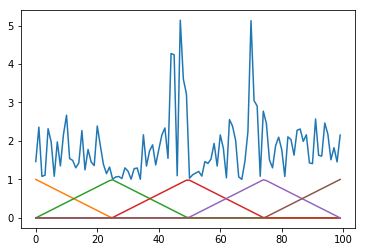

In [3]:
nodes = 5
g = grid(nodes)
plt.plot([κ(x, np.random.rand(nodes), g) for x in np.linspace(0, 1, num=100)])

for i in range(nodes):
    plt.plot([tent(x, i, g) for x in np.linspace(0, 1, num=100)])
plt.show()

In [4]:
nodes = 10
pars = np.random.randn(nodes)
g = grid(nodes)
aa = A(lambda x: κ(x, pars, g), g)
bb = b(lambda x: np.cos(x), g)

np.linalg.solve(aa, bb)

array([ 7.2758055 ,  8.29709789, 18.96445452, 23.34774462, 22.59827513,
       21.74059444, 10.88475468,  5.15230854])

# Forward Solver Using Tensorflow and Edward

In [2]:
import edward as ed
import tensorflow as tf
from edward.models import Empirical, Normal

In [5]:
mu = Normal(loc=0.0, scale=1.0)
x = Normal(loc=mu, scale=1.0, sample_shape=10)

qmu = Empirical(tf.Variable(tf.zeros(500)))
inference = ed.SGHMC({mu: qmu}, {x: np.zeros(10, dtype=np.float32)})

C:\ProgramData\Anaconda3\lib\site-packages\edward\util\random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


In [25]:
qmu_trace = qmu.params.eval()
print(qmu_trace)

[ 0.00000000e+00 -3.78917233e-04 -2.24297270e-02 -8.12717378e-02
 -1.40063196e-01 -1.82425380e-01 -2.24133655e-01 -2.65791237e-01
 -2.95203567e-01 -3.48400235e-01 -4.04184133e-01 -4.62325037e-01
 -5.01730323e-01 -5.31851828e-01 -5.35615921e-01 -4.94327158e-01
 -4.61050034e-01 -4.03151155e-01 -3.28953594e-01 -2.47926816e-01
 -1.56210795e-01 -4.13958877e-02  5.61461970e-02  1.39729410e-01
  2.22370207e-01  2.94131547e-01  3.94256860e-01  4.73358691e-01
  5.24380326e-01  5.44491768e-01  5.56733310e-01  5.34601986e-01
  5.04046857e-01  4.58618134e-01  4.05423164e-01  3.38127434e-01
  2.54159898e-01  1.45619512e-01  5.29360026e-02 -2.08529979e-02
 -1.03357218e-01 -1.54186502e-01 -2.04580486e-01 -2.39028901e-01
 -2.51037329e-01 -2.47651294e-01 -2.37610504e-01 -2.15038911e-01
 -1.99533358e-01 -1.59844875e-01 -1.31965905e-01 -9.02381390e-02
 -5.58280684e-02 -3.24312337e-02 -1.55298170e-02 -1.30436830e-02
 -2.50073764e-02 -4.52604443e-02 -5.03287278e-02 -1.37435533e-02
  2.72902437e-02  3.73658

In [23]:
plt.plot(x)
plt.show()

TypeError: unsupported operand type(s) for /: 'Dimension' and 'int'

# Inverse Problem

Given our Darcy Flow system, some coefficents of $u_{i}$ corrupted by additive noise $\mathcal{N}(0, \sigma^{2})$, and knowledge of $f(x)$, it is our job to infer the paramters $k_{\alpha}$. 

This section referse to a case where:

\begin{equation}
    - \frac{d}{dx}(e^{u(x)} \frac{dp}{dx}(x)) = f(x)
\end{equation}

Data, In this case, we assume we have 3 data points:

\begin{align}
    y &= [u(x_{1}), u(x_{4}), u(x_{9})] + \mathcal{N}(0, \sigma^{2})
\end{align}

Centered gaussian prior on u:

\begin{equation}
    \text{log prior density}(u) = - \sum_{k=1}^{A} \rho_k^2 (u_k)^2, \rho_k \sim \frac{1}{k}
\end{equation}

Write G for the u-to-y map, $G: \mathbb{R}^K \rightarrow \mathbb{R}^3$. (3 because we have 3 data points.)

\begin{equation}
    G(u) = [u(x_{1}), u(x_{4}), u(x_{9})]
\end{equation}

Gaussian observerd noise:

\begin{equation}
    \text{log likelihood}(u) = - \frac{1}{2 \sigma^2} ||G(u) - y||_{\mathbb{R}^3, 2}^{2}
\end{equation}

Log posterior to sample from (u|y)

\begin{equation}
    \text{log posterior}(u|y) = - \frac{1}{2 \sigma^2} ||G(u) - y||_{\mathbb{R}^3, 2}^{2} + \sum_{k=1}^{A} \rho_k^2 u_k^2
\end{equation}

The functions below use notation consistent with the forward solver

In [7]:
import scipy.stats

In [ ]:
# Random Walk MCMC Function
def metropolis_step(state, proposal_dist, target_dist):
    proposed_state = state + proposal_dist.rvs()

    acceptance_prob = min([0, target_dist(proposed_state) - target_dist(state)])

    if acceptance_prob > 0 or np.log(np.random.rand()) <= acceptance_prob:
        return proposed_state
    else:
        return state

In [5]:
def G_pre(k, f, grid):
    """(almost) Returns a vector of the forward solver given the vector of k_alphas."""
    aa = A(lambda x: κ(x, k, grid), grid)
    bb = b(f, grid)

    return aa, bb

def spec_metropolis_step(state, data, data_inds, noise_sigma, prop_sigma, f, grid):
    def GG(f, grid):
        def gg(k):
            aa, bb = G_pre(k, f, grid)
            return np.linalg.solve(aa, bb)
        return gg
    
    G = GG(f, grid)
    
    proposal_dist = scipy.stats.multivariate_normal(np.zeros_like(grid),
                                                    np.eye(grid.shape[0]) * prop_sigma ** 2)
    proposed_state = state + proposal_dist.rvs()
    alpha = (np.linalg.norm(data - G(state)[data_inds]) ** 2 -
             np.linalg.norm(data - G(proposed_state)[data_inds]) ** 2) / (2 * noise_sigma ** 2)
    alpha += (np.linalg.norm(state) ** 2 - np.linalg.norm(proposed_state)) / (2 * prop_sigma ** 2)
    
    if alpha > 0 or np.log(np.random.rand()) <= alpha:
        return proposed_state
    else:
        return state
    

def target(data, data_inds, prior_k, prior_sigma, noise_sigma, f, grid):
    def logposterior(x):
        aa, bb = G_pre(x, f, grid)
        return -( 
            (1/(2 * noise_sigma**2) * (np.linalg.solve(aa, bb)[data_inds] - data) + 
             prior_k.norm / (2 * prior_sigma**2))
        )
    return logposterior

In [10]:
# MCMC Execution
data = np.asarray([1,.5,0.2])
data_inds = [0, 3, 7]
f = lambda x: 1

noise_sigma = 1
prop_sigma = 1

nodes = 10
g = grid(nodes)
states = [np.zeros_like(g)]
steps = 10

for i in range(steps):
    states.append(spec_metropolis_step(states[-1], 
                                       data,
                                       data_inds,
                                       noise_sigma,
                                       prop_sigma,
                                       f,
                                       g))
    
states = np.asarray(states)

In [22]:
import pymc3 as pm
from sampled import sampled
import theano.tensor as tt

In [41]:
def G_pre(k, f, grid):
    """(almost) Returns a vector of the forward solver given the vector of k_alphas."""
    aa = A(lambda x: κ(x, k, grid), grid)
    bb = b(f, grid)

    return aa, bb
#     return np.linalg.solve(aa, bb)

def tt_distribution(data, data_inds, prior_k, prior_sigma, noise_sigma, f, grid):
    def logposterior(x):
        aa, bb = G_pre(x, f, grid)
        return - (1/(2 * noise_sigma**2) (tt.slinalg.solve(aa, bb)[data_inds] - data) + prior_k.norm / (2 * prior_sigma**2))
    return logposterior

g = grid(10)
@sampled
def post(data, data_inds, prior_k, grid, prior_sigma=1, noise_sigma=1, f=lambda x:1):
    dim = grid.shape[0]
    testval = np.zeros(dim)
    pm.DensityDist('post', 
                   logp=tt_distribution(data, data_inds, prior_k, prior_sigma, noise_sigma, f, grid), 
                   shape=dim, 
                   testval=testval)

In [45]:
data = np.asarray([1,1,1,1])
data_inds = np.arange(data.shape[0])
prior_k = np.asarray([1,1,1,1])
g = grid(data.shape[0])

with post(data=data, data_inds=data_inds, prior_k=prior_k, grid=g):
    step = pm.NUTS()
    metropolis_sample = pm.sample(draws=1000, step=step, 
                                  tune=500, discard_tuned_samples=True)

TypeError: post() missing 4 required positional arguments: 'data', 'data_inds', 'prior_k', and 'grid'

In [46]:
oo = tt_distribution(np.asarray([1,1,1,1]), [0,1,2,3], np.asarray([1,1,1,1]), 1, 1, lambda x:1, grid(3))
G_pre(np.asarray([1,1,1,1]), lambda x:1, grid(4))
oo(np.array[1,1,1])

TypeError: 'builtin_function_or_method' object is not subscriptable

In [16]:
def linear(A):
    
    def G(u):
        
    return g

def tt_posterior(G, y, gamma, sigma):
    
    def logp(u):
        - tt.dot((y - G(u)).T, y - G(u))/(2 * gamma ** 2) - tt.dot(u.T, u)/(2 * sigma ** 2)
    return logp

IndentationError: expected an indented block (<ipython-input-16-81cf750d12f9>, line 5)

In [47]:
# https://stackoverflow.com/questions/42678490/custom-theano-op-to-do-numerical-integration?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

import theano
import theano.tensor as T
from scipy.integrate import quad

class integrateOut(theano.Op):
    """
    Integrate out a variable from an expression, computing
    the definite integral w.r.t. the variable specified
    !!! Only implemented in this for scalars !!!


    Parameters
    ----------
    f : scalar
        input 'function' to integrate
    t : scalar
        the variable to integrate out
    t0: float
        lower integration limit
    tf: float
        upper integration limit

    Returns
    -------
    scalar
        a new scalar with the 't' integrated out

    Notes
    -----

    usage of this looks like:
    x = T.dscalar('x')
    y = T.dscalar('y')
    t = T.dscalar('t')

    z = (x**2 + y**2)*t

    # integrate z w.r.t. t as a function of (x,y)
    intZ = integrateOut(z,t,0.0,5.0)(x,y)
    gradIntZ = T.grad(intZ,[x,y])

    funcIntZ = theano.function([x,y],intZ)
    funcGradIntZ = theano.function([x,y],gradIntZ)

    """
    def __init__(self,f,t,t0,tf,*args,**kwargs):
        super(integrateOut,self).__init__()
        self.f = f
        self.t = t
        self.t0 = t0
        self.tf = tf

    def make_node(self,*inputs):
        self.fvars=list(inputs)
        # This will fail when taking the gradient... don't be concerned
        try:
            self.gradF = T.grad(self.f,self.fvars)
        except:
            self.gradF = None
        return theano.Apply(self,self.fvars,[T.dscalar().type()])

    def perform(self,node, inputs, output_storage):
        # Everything else is an argument to the quad function
        args = tuple(inputs)
        # create a function to evaluate the integral
        f = theano.function([self.t]+self.fvars,self.f)
        # actually compute the integral
        output_storage[0][0] = quad(f,self.t0,self.tf,args=args)[0]

    def grad(self,inputs,grads):
        return [integrateOut(g,self.t,self.t0,self.tf)(*inputs)*grads[0] \
            for g in self.gradF]

x = T.dscalar('x')
y = T.dscalar('y')
t = T.dscalar('t')

z = (x**2+y**2)*t

intZ = integrateOut(z,t,0,1)(x,y)
gradIntZ = T.grad(intZ,[x,y])
funcIntZ = theano.function([x,y],intZ)
funcGradIntZ = theano.function([x,y],gradIntZ)
print(funcIntZ(2,2))
print(funcGradIntZ(2,2))

ValueError: Cannot compute test value: input 0 (x) of Op Elemwise{pow,no_inplace}(x, TensorConstant{2}) missing default value.  
Backtrace when that variable is created:

  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-62d4c6998578>", line 75, in <module>
    x = T.dscalar('x')


In [ ]:
def tt_banana_pdf(mean, cov, warp):
    mean = np.asarray(mean)
    cov = np.asarray(cov)
    dim = mean.shape[0]
    
    constant = -np.log((2*np.pi)**dim * np.linalg.det(cov))/2
    covinv = np.linalg.inv(cov)
    
    def logp(x):
        distortion = np.ones(dim) * warp * x[0]**2
        tt.set_subtensor(distortion[0], 0)
        return constant - tt.dot(tt.dot((x + distortion - mean).T, covinv), (x + distortion - mean))/2
    return logp

@sampled
def banana(mean=[0,0], cov=[[1,0],[0,1]], warp=0.9, **observed):
    mean = np.asarray(mean)
    cov = np.asarray(cov)
    dim = mean.shape[0]
    testval = np.zeros(dim)
    pm.DensityDist('banana', logp=tt_banana_pdf(mean, cov, warp), shape=dim, testval=testval)

In [ ]:
dim = 2
mean = np.zeros(dim)
cov = np.eye(dim)/dim
warp = 0.5

starting_point = np.zeros(dim)

with banana(mean=mean, cov=cov, warp=warp):
    step = pm.Metropolis()
    step = pm.NUTS()
    metropolis_sample = pm.sample(draws=1000, step=step, 
                                  start={'banana': starting_point}, 
                                  tune=500, discard_tuned_samples=True)